# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [220]:
input_freq = Params(
    f = 50
)

,values
f,50


In [221]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,50.000000
vin,0.000000


In [222]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * input_freq.f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [223]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.0049
cutoff,32.4806


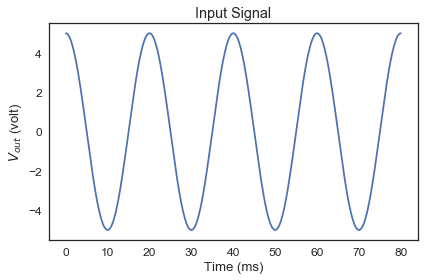

In [224]:
x = linspace(0, system1.t_end * 1000, 401)
v = A * np.cos(2 * pi * (f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

In [225]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [226]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [227]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

In [228]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.0000 0.000000 0.0002 0.199840 0.0004 ...


In [229]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.1
cutoff,1.59155


In [230]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = ((vin(t) - vout) * (system.R * system.C * system.omega)) / (system.R * system.C)
    
    return dvoutdt

In [231]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [232]:
results2, details2 = run_ode_solver(system2, slope_func_high_pass, t_eval=system2.ts)

In [233]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.0000 0.000000 0.0002 0.006138 0.0004 ...


In [234]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.00499
cutoff,31.8948


In [235]:
results3, details3 = run_ode_solver(system3, slope_func_low_pass, t_eval=system3.ts)

In [236]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.0000 0.000000 0.0002 0.000120 0.0004 ...


In [237]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.0049
cutoff,32.4806


In [238]:
results4, details4 = run_ode_solver(system4, slope_func_low_pass, t_eval=system4.ts)

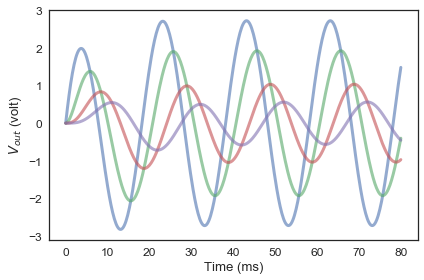

In [239]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

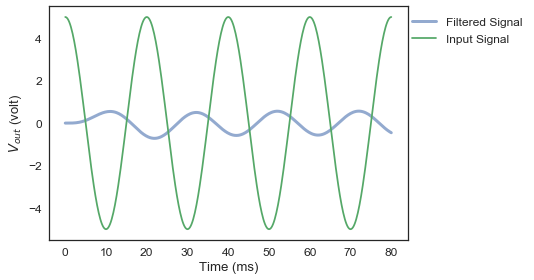

In [240]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], loc='upper right', bbox_to_anchor=(1.35, 1))

In [124]:
params_total = Params(
    R1 = 4.9e3,   # ohm
    C1 = 1e-6,  # farad
    
    vin2 = results1.V_out,
    R2 = 100e3,   # ohm
    C2 = 1e-6,  # farad
    
    vin3 = results2.V_out,
    R3 = 499,   # ohm
    C3 = 10e-6,  # farad
    
    vin4 = results3.V_out,
    R4 = 4.9e3,   # ohm
    C4 = 1e-6  # farad
)

,values
R1,4900
C1,1e-06
vin2,0.00 0.000000 0.02 4.908877 0.04 4.96...
R2,100000
C2,1e-06
vin3,0.00 0.000000 0.02 0.140523 0.04 0.42...
R3,499
C3,1e-05
vin4,0.00 0.000000 0.02 0.105790 0.04 0.35...
R4,4900


In [125]:
def amp(R):
    G = 1 + (100e3/R)
    return G

In [126]:
G1 = amp(2e3)
G2 = amp(4.9e3);

In [210]:
def run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2):
    
    params5 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5 * G1,      # volt
    f = input_freq.f,   # Hz
    vin = 0
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, slope_func_init, t_eval=system5.ts)
    
    params6 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, slope_func_high_pass, t_eval=system6.ts)
    
    params7 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results6.V_out * G2
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, slope_func_low_pass, t_eval=system7.ts)
    
    params8 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, slope_func_low_pass, t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, results6=results6, result7=results7, results8=results8, ratio=ratio)

In [211]:
input_freq.f = 50

In [212]:
results5, results6, results7, results8, ratio = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2)

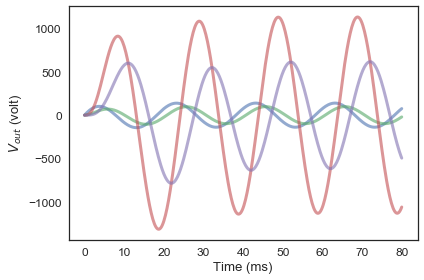

In [213]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [214]:
sweep = SweepSeries()
for f in linspace(0.5, 100, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass, G1, G2).ratio
    sweep[f] = state;

0.500000      15.233031
2.530612      15.087256
4.561224      14.787505
6.591837      14.335391
8.622449      13.761977
10.653061     13.090916
12.683673     12.347997
14.714286     11.572733
16.744898     10.786299
18.775510     10.006409
20.806122      9.247044
22.836735      8.528039
24.867347      7.841628
26.897959      7.204132
28.928571      6.613908
30.959184      6.065120
32.989796      5.561387
35.020408      5.102149
37.051020      4.681487
39.081633      4.295267
41.112245      3.945844
43.142857      3.629406
45.173469      3.338143
47.204082      3.072500
49.234694      2.830819
51.265306      2.611768
53.295918      2.434379
55.326531      2.278786
57.357143      2.136585
59.387755      2.003929
61.418367      1.879934
63.448980      1.766313
65.479592      1.661576
67.510204      1.561637
69.540816      1.471908
71.571429      1.386281
73.602041      1.307405
75.632653      1.232931
77.663265      1.164202
79.693878      1.099993
81.724490      1.040250
83.755102      0

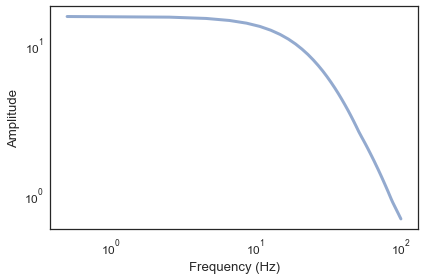

In [215]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')

print(sweep)

In [216]:
from pandas import read_csv
data = read_csv("Bode Plot Data Two Channel Adjusted.csv")
data.columns = ["Frequency", "Amplitude1", "Amplitude2"]
print(data)

    Frequency  Amplitude1  Amplitude2
0    1.204622    1.336704    7.892721
1    1.394753    2.062281    7.447578
2    1.614894    2.720442    6.957306
3    1.869782    3.309978    6.506548
4    2.164899    3.832494    6.041254
5    2.506597    4.289950    5.543557
6    2.902226    4.685360    5.103302
7    3.360299    5.021772    4.687570
8    3.890673    5.305573    4.287470
9    4.504759    5.534682    3.906275
10   5.215768    5.710039    3.533519
11   6.039000    5.834386    3.155440
12   6.992167    5.909790    2.756838
13   8.095778    5.936137    2.324386
14   9.373577    5.912632    1.843787
15  10.853058    5.834932    1.306494
16  12.566053    5.702385    0.701586
17  14.549419    5.513495    0.023472
18  16.845831    5.264004   -0.726697
19  19.504696    4.946740   -1.541431
20  22.583225    4.554394   -2.408142
21  26.147654    4.080540   -3.317242
22  30.274676    3.520765   -4.257796
23  35.053087    2.875092   -5.225047
24  40.585699    2.145339   -6.203025
25  46.99155

In [217]:
def plot_data(data):
    f = (data.Frequency.index / 2 * np.pi)
    a = (data.Amplitude2.values)
       
    plot(f, a)
    decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Collected Data',
             legend=False)

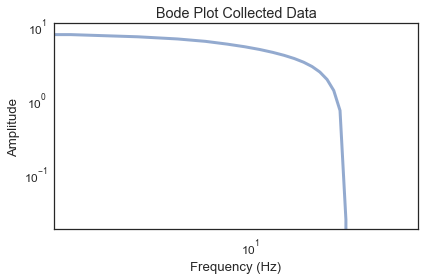

In [218]:
plot_data(data)

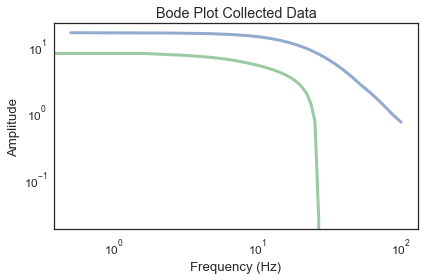

In [219]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             title='Bode Plot Simulated VS Collected Data')
plot_data(data)